In [35]:
# importing modules
import os
import cv2

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report

%matplotlib inline

In [8]:
tf.version.VERSION

'2.10.0'

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
DATASET_PATH = './datasets/model_data'

IMG_W = 256
IMG_H = 72
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 50

input_shape = (IMG_H, IMG_W, CHANNELS)

weight_decay = 0.005
learning_rate = 0.05
lr_decay = 1e-6
lr_drop = 25

## Dataset Loading

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    f'{DATASET_PATH}/train',
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 780 images belonging to 15 classes.


In [12]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    f'{DATASET_PATH}/val',
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 91 images belonging to 15 classes.


In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    f'{DATASET_PATH}/test',
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 111 images belonging to 15 classes.


In [14]:
for image_batch, label_batch in train_generator:
    print(image_batch.shape)
    break

(32, 72, 256, 3)


## Plotting

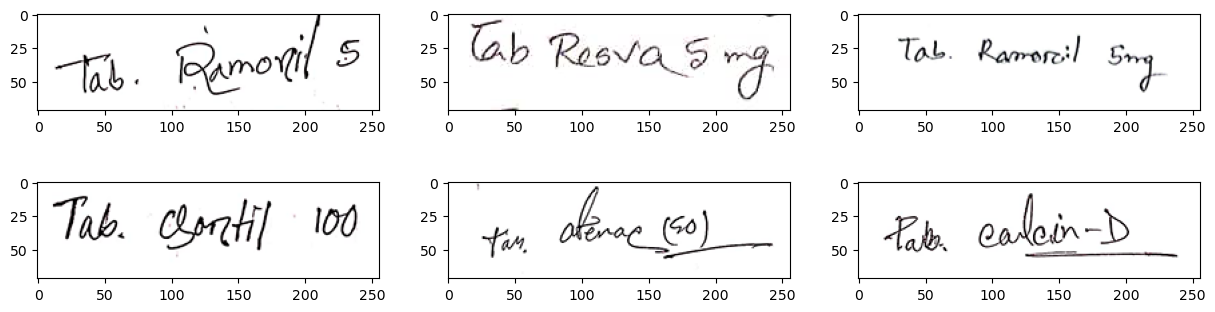

In [15]:
images, labels = train_generator.next()
plt.figure(figsize=(15, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i], cmap='gray')
plt.show()

In [16]:
def plot_accuracy(history, model_name=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(25, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(50), acc, label='Training Accuracy')
    plt.plot(range(50), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(
        f'Training and Validation Accuracy {f"for {model_name}" if model_name else ""}')

    plt.subplot(1, 2, 2)
    plt.plot(range(50), loss, label='Training Loss')
    plt.plot(range(50), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(
        f'Training and Validation Loss {f"for {model_name}" if model_name else ""}')
    plt.savefig('./figures/model_accuracy.png')
    plt.show()

## Model Training

In [17]:
model = tf.keras.models.Sequential([
    # Conv 1
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    # Conv 2
    Conv2D(64,  kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    # Conv 3
    Conv2D(96,  kernel_size=(4, 4), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    # Conv 4
    Conv2D(96, (4, 4), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    # Conv 5
    Conv2D(96, (4, 4), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    # Conv 6
    Conv2D(128, (4, 4), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(38, activation='softmax')
])

In [18]:
model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 70, 254, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 127, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 127, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 63, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 17, 63, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 63, 96)        9

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_generator
)

Epoch 1/50
25/25 [==============================] - 48s 524ms/step - loss: 3.0371 - accuracy: 0.0833 - val_loss: 3.0571 - val_accuracy: 0.0769
Epoch 2/50
25/25 [==============================] - 2s 69ms/step - loss: 2.7605 - accuracy: 0.0667 - val_loss: 2.9041 - val_accuracy: 0.0769
Epoch 3/50
25/25 [==============================] - 2s 68ms/step - loss: 2.7380 - accuracy: 0.0718 - val_loss: 2.8647 - val_accuracy: 0.0989
Epoch 4/50
25/25 [==============================] - 2s 67ms/step - loss: 2.7311 - accuracy: 0.0769 - val_loss: 2.8960 - val_accuracy: 0.0769
Epoch 5/50
25/25 [==============================] - 2s 69ms/step - loss: 2.7309 - accuracy: 0.0821 - val_loss: 2.8590 - val_accuracy: 0.0769
Epoch 6/50
25/25 [==============================] - 2s 67ms/step - loss: 2.7186 - accuracy: 0.0859 - val_loss: 2.8084 - val_accuracy: 0.0989
Epoch 7/50
25/25 [==============================] - 2s 63ms/step - loss: 2.7065 - accuracy: 0.0859 - val_loss: 2.7480 - val_accuracy: 0.0879
Epoch 8/50


In [24]:
scores = model.evaluate(test_generator)
scores

4/4 [==============================] - 1s 399ms/step - loss: 0.1111 - accuracy: 0.9459


[0.11110819876194, 0.9459459185600281]

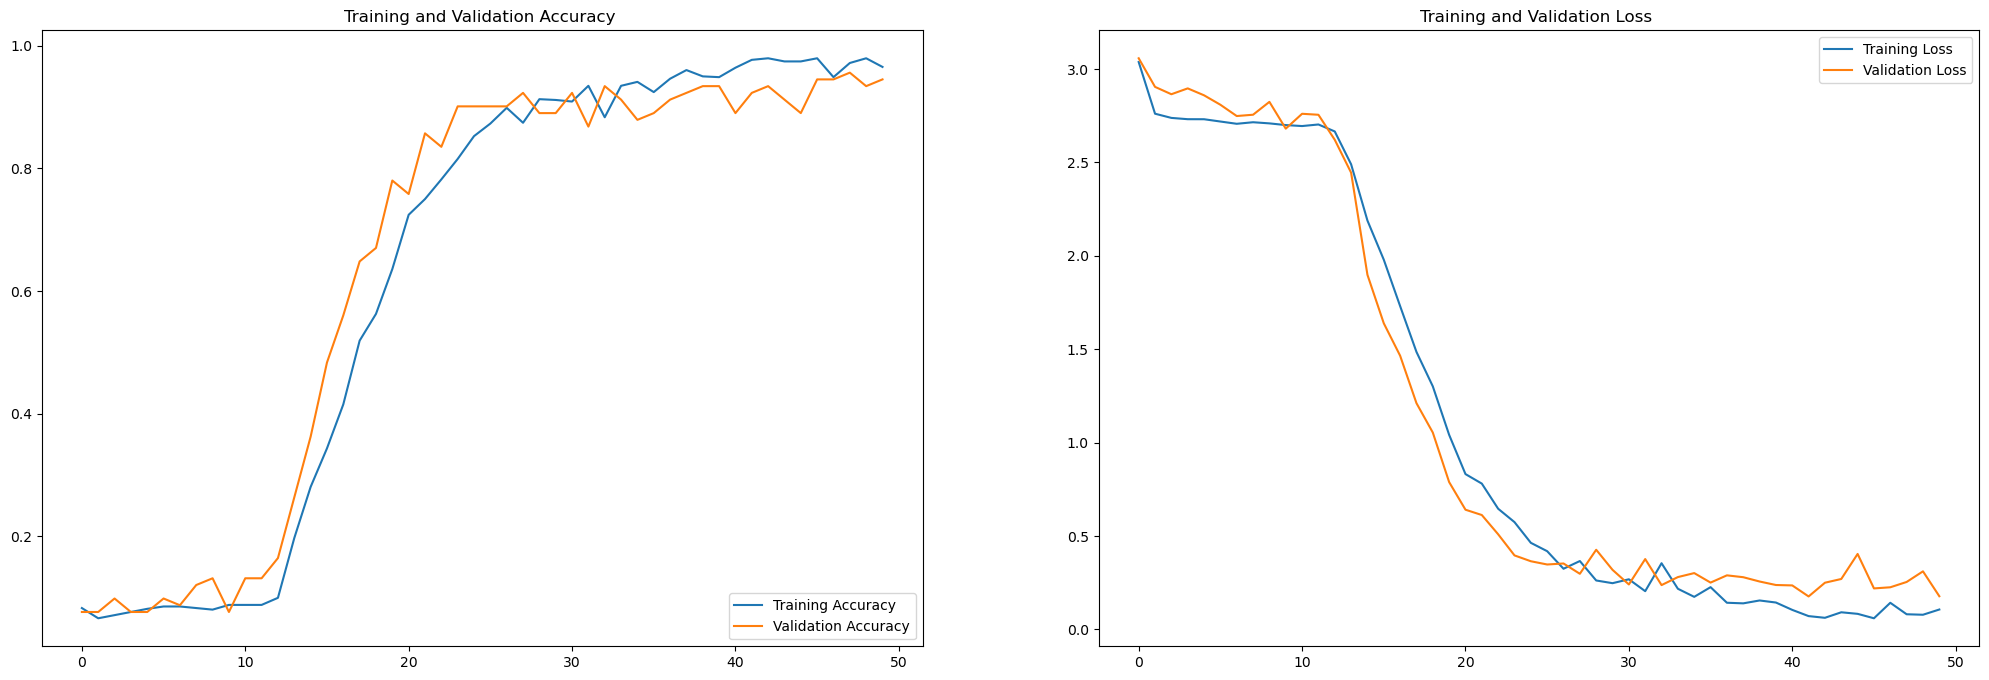

In [25]:
plot_accuracy(history)

In [26]:
class_names = list(train_generator.class_indices.keys())
class_names

['Tab. Afenac 50mg',
 'Tab. Calcin D',
 'Tab. Finix 20mg',
 'Tab. Fixal 120mg',
 'Tab. Napa Extend 665mg',
 'Tab. Naprosyn 500mg',
 'Tab. Napsod 550mg',
 'Tab. Nitrin SR 2.6mg',
 'Tab. Osartil 100mg',
 'Tab. Ovocal-DX',
 'Tab. Ramoril 5mg',
 'Tab. Resva 5mg',
 'Tab. Rivotril 0.5mg',
 'Tab. Riz 10mg',
 'Tab. V-Plex']

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [28]:
img = r"D:\CSE400\porjects\docs-handwriting-recognizer\model\datasets\model_data\test\Tab. Riz 10mg\7.png"
img = cv2.imread(img)
predict(model, img)

1/1 [==============================] - 1s 648ms/step


('Tab. Riz 10mg', 100.0)

## Building Confusion Matrix

In [80]:
data_dict = {'actual_class': [], 'predicted_class': [], 'probability': []}

for class_ in os.listdir(os.path.join(DATASET_PATH, 'test')):
    class_path = os.path.join(test_dir, class_)
    for file in os.listdir(class_path):
        img = f'{os.path.join(class_path, file)}'
        img = cv2.imread(img)
        pred, prob = predict(model, img)
        data_dict['actual_class'].append(class_)
        data_dict['predicted_class'].append(pred)
        data_dict['probability'].append(prob)
result_df = pd.DataFrame(data=data_dict)

1/1 [==============================] - 0s 23ms/step


In [81]:
try:
    os.makedirs('results')
except Exception as e:
    print(e)
finally:
    result_df.to_csv('results/result.csv')

[WinError 183] Cannot create a file when that file already exists: 'results'


### Visualizing Confusion Matrix and Calculating other Evaluation Metrices

In [82]:
model_result_df = pd.read_csv('results/result.csv')
model_result_df.head()

,Unnamed: 0,actual_class,predicted_class,probability
0,0,Tab. Afenac 50mg,Tab. Nitrin SR 2.6mg,100.0
1,1,Tab. Afenac 50mg,Tab. Finix 20mg,100.0
2,2,Tab. Afenac 50mg,Tab. Afenac 50mg,100.0
3,3,Tab. Afenac 50mg,Tab. Afenac 50mg,100.0
4,4,Tab. Afenac 50mg,Tab. Finix 20mg,100.0


In [83]:
confusion_matrix = pd.crosstab(model_result_df.predicted_class,
                    model_result_df.actual_class)
confusion_matrix

actual_class,Tab. Afenac 50mg,Tab. Calcin D,Tab. Finix 20mg,Tab. Fixal 120mg,Tab. Napa Extend 665mg,Tab. Naprosyn 500mg,Tab. Napsod 550mg,Tab. Nitrin SR 2.6mg,Tab. Osartil 100mg,Tab. Ovocal-DX,Tab. Ramoril 5mg,Tab. Resva 5mg,Tab. Rivotril 0.5mg,Tab. Riz 10mg,Tab. V-Plex
predicted_class,,,,,,,,,,,,,,,
Tab. Afenac 50mg,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tab. Calcin D,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0
Tab. Finix 20mg,2,0,4,0,0,0,0,0,0,0,0,0,0,0,0
Tab. Fixal 120mg,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0
Tab. Napa Extend 665mg,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0
Tab. Naprosyn 500mg,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0
Tab. Napsod 550mg,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0
Tab. Nitrin SR 2.6mg,1,0,0,0,0,0,0,8,0,0,0,0,0,0,0
Tab. Osartil 100mg,0,0,0,0,0,0,0,0,6,0,0,0,1,0,0


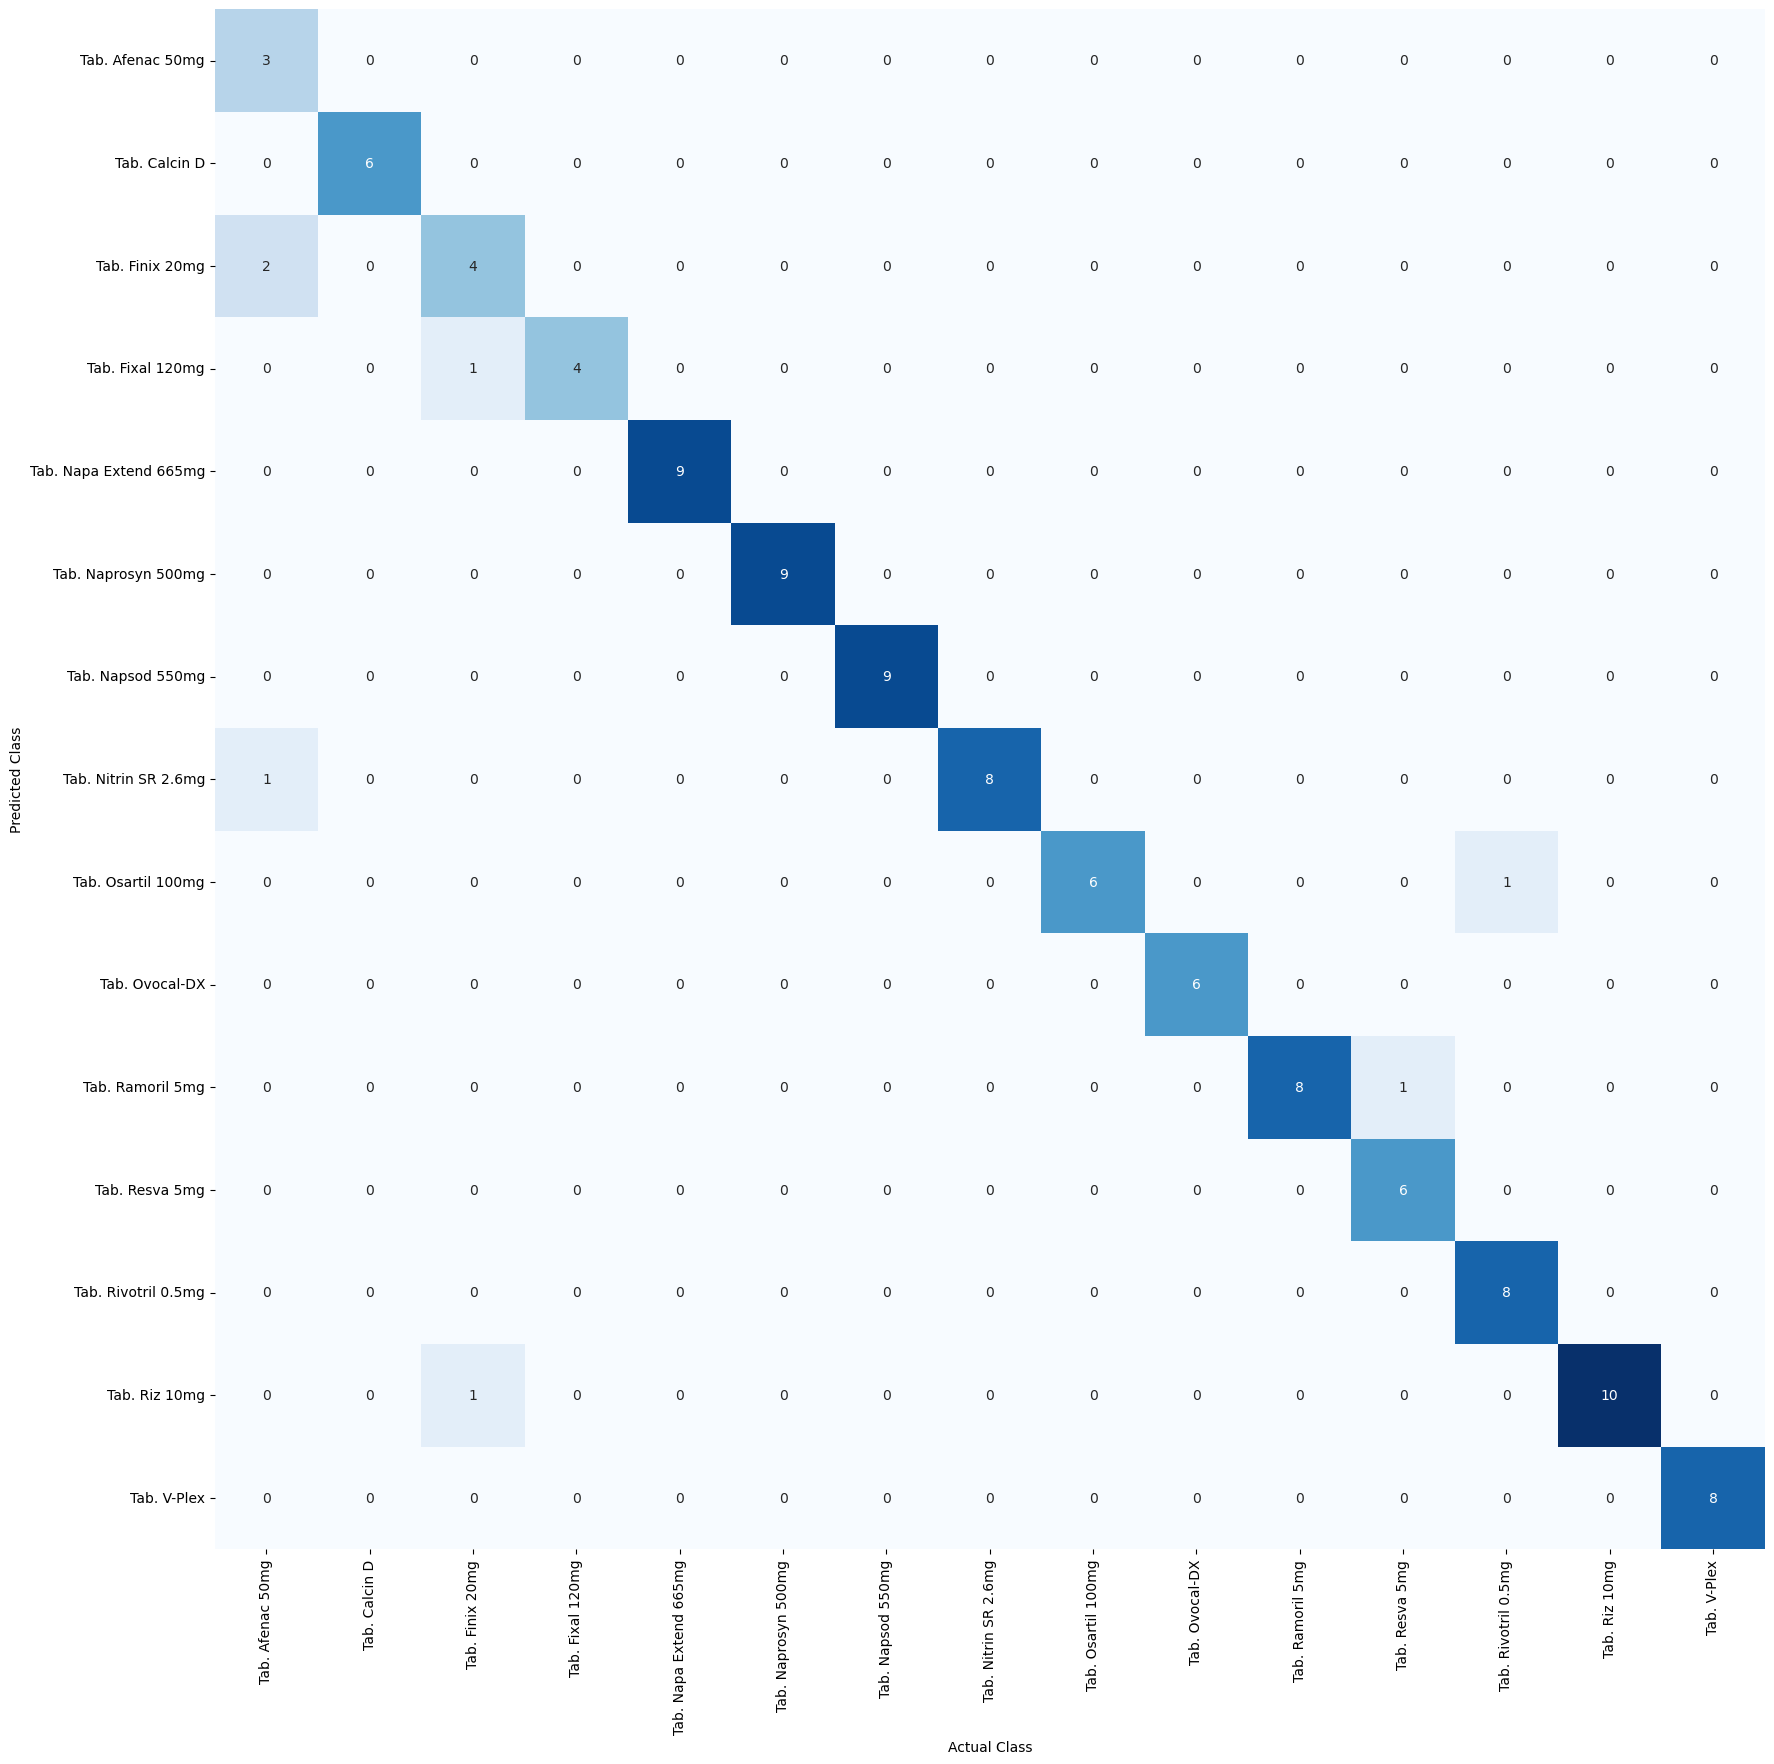

In [84]:
fig = plt.figure(figsize=(20, 20))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')
plt.savefig('./figures/confusion_matrix.png')
plt.show()

In [85]:
def accuracy(matrix):
    return np.diag(matrix).sum() / matrix.sum().sum()

In [86]:
accuracy(confusion_matrix)

0.9369369369369369

In [87]:
def accuracy_for_class(matrix, idx: int):
    TP = matrix.iloc[idx, idx]
    FP = matrix.iloc[idx, :].sum()-TP
    FN = matrix.iloc[:, idx].sum()-TP
    TN = matrix.sum().sum()-TP-FP-FN
    return (TP+TN) / matrix.sum().sum()

In [88]:
def precision_for_class(matrix, idx: int):
    TP = matrix.iloc[idx, idx]
    FP = matrix.iloc[idx, :].sum()-TP
    FN = matrix.iloc[:, idx].sum()-TP
    return TP / (TP+FP)

In [89]:
def recall_for_class(matrix, idx: int):
    TP = matrix.iloc[idx, idx]
    FP = matrix.iloc[idx, :].sum()-TP
    FN = matrix.iloc[:, idx].sum()-TP
    return TP / (TP+FN)

In [90]:
def f1_for_class(matrix, idx: int):
    precision = precision_for_class(matrix, idx)
    recall = recall_for_class(matrix, idx)
    return (2*precision*recall) / (precision+recall)

In [91]:
for i in range(confusion_matrix.shape[0]):
    accuracy = accuracy_for_class(confusion_matrix, i)
    precision = precision_for_class(confusion_matrix, i)
    recall = recall_for_class(confusion_matrix, i)
    f1 = f1_for_class(confusion_matrix, i)
    
    print(confusion_matrix.index[i])
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')
    print('----------------------------', end='\n\n')

Tab. Afenac 50mg
Accuracy: 0.972972972972973
Precision: 1.0
Recall: 0.5
F1: 0.6666666666666666
----------------------------

Tab. Calcin D
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
----------------------------

Tab. Finix 20mg
Accuracy: 0.963963963963964
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F1: 0.6666666666666666
----------------------------

Tab. Fixal 120mg
Accuracy: 0.990990990990991
Precision: 0.8
Recall: 1.0
F1: 0.888888888888889
----------------------------

Tab. Napa Extend 665mg
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
----------------------------

Tab. Naprosyn 500mg
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
----------------------------

Tab. Napsod 550mg
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
----------------------------

Tab. Nitrin SR 2.6mg
Accuracy: 0.990990990990991
Precision: 0.8888888888888888
Recall: 1.0
F1: 0.9411764705882353
----------------------------

Tab. Osartil 100mg
Accuracy: 0.990990990990991
Precision: 0.85

In [92]:
pd.DataFrame(data=classification_report(
        model_result_df['actual_class'],
        model_result_df['predicted_class'],
        output_dict=True)).T

,precision,recall,f1-score,support
Tab. Afenac 50mg,1.000000,0.500000,0.666667,6.000000
Tab. Calcin D,1.000000,1.000000,1.000000,6.000000
Tab. Finix 20mg,0.666667,0.666667,0.666667,6.000000
Tab. Fixal 120mg,0.800000,1.000000,0.888889,4.000000
Tab. Napa Extend 665mg,1.000000,1.000000,1.000000,9.000000
Tab. Naprosyn 500mg,1.000000,1.000000,1.000000,9.000000
Tab. Napsod 550mg,1.000000,1.000000,1.000000,9.000000
Tab. Nitrin SR 2.6mg,0.888889,1.000000,0.941176,8.000000
Tab. Osartil 100mg,0.857143,1.000000,0.923077,6.000000
Tab. Ovocal-DX,1.000000,1.000000,1.000000,6.000000


## Saving the Model

In [93]:
model_version = max([int(i) for i in os.listdir('save_models') + [0]]) + 1
model.save(f'./save_models/{model_version}')
model.save(f'./h5/model_{model_version}.h5')

INFO:tensorflow:Assets written to: ./save_models/3\assets


INFO:tensorflow:Assets written to: ./save_models/3\assets
